In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


100%|██████████| 170498071/170498071 [00:01<00:00, 89177193.25it/s]


Extracting ./CIFAR10/train/cifar-10-python.tar.gz to ./CIFAR10/train


100%|██████████| 170498071/170498071 [00:01<00:00, 98827351.12it/s] 


Extracting ./CIFAR10/test/cifar-10-python.tar.gz to ./CIFAR10/test


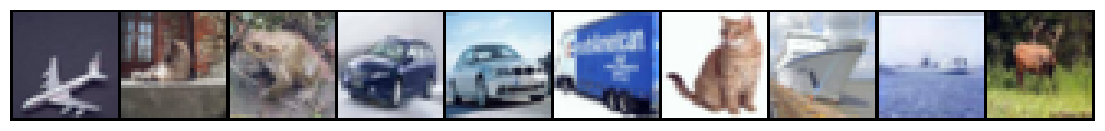

airplane cat frog automobile automobile truck cat ship ship deer 

In [3]:

plt.rcParams['figure.figsize'] = 14, 6

mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2435, 0.2616]


normalize_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = mean,
                                     std = std)])


train_dataset = torchvision.datasets.CIFAR10(
    root="./CIFAR10/train", train=True,
    transform=normalize_transform,
    download=True)



test_dataset = torchvision.datasets.CIFAR10(
    root="./CIFAR10/test", train=False,
    transform=normalize_transform,
    download=True)

indices = list(range(len(test_dataset)))

val_indices, test_indices = train_test_split(indices, test_size=0.5, random_state=42)



batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)


val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
validation_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, sampler=val_sampler)


test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler)

dataiter = iter(train_loader)
images, labels = next(dataiter)
plt.imshow(np.transpose(torchvision.utils.make_grid(
  images[:10], normalize=True, padding=1, nrow=10).numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()


label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
               "horse", "ship", "truck"]
labels_now = labels[:10]
for x in labels_now.tolist():
  print(label_names[x], end=" ")

Defining a Convolutional Neural Network

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 5, padding='same')
        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(8, 16, 5, padding='same')
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 32, 5, padding='same')
        self.bn3 = nn.BatchNorm2d(32)

        self.fc1 = nn.Linear(32 * 4 * 4, 128)

        self.fc2 = nn.Linear(128, 64)

        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.bn1(self.relu(self.conv1(x))))
        x = self.pool(self.bn2(self.relu(self.conv2(x))))
        x = self.pool(self.bn3(self.relu(self.conv3(x))))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


net = Net().to(device)

In [5]:
print(net)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [6]:
from torchsummary import summary
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             608
              ReLU-2            [-1, 8, 32, 32]               0
       BatchNorm2d-3            [-1, 8, 32, 32]              16
         MaxPool2d-4            [-1, 8, 16, 16]               0
            Conv2d-5           [-1, 16, 16, 16]           3,216
              ReLU-6           [-1, 16, 16, 16]               0
       BatchNorm2d-7           [-1, 16, 16, 16]              32
         MaxPool2d-8             [-1, 16, 8, 8]               0
            Conv2d-9             [-1, 32, 8, 8]          12,832
             ReLU-10             [-1, 32, 8, 8]               0
      BatchNorm2d-11             [-1, 32, 8, 8]              64
        MaxPool2d-12             [-1, 32, 4, 4]               0
           Linear-13                  [-1, 128]          65,664
          Dropout-14                  [

Defining a Loss function and optimizer

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Training the network

In [8]:
train_loss_history=[]
test_loss_history=[]
start_time = time.time()
for epoch in range(30):

    running_train_loss = 0.0

    for data in train_loader:

        inputs, labels = data[0].to(device), data[1].to(device)



        optimizer.zero_grad()


        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        running_train_loss += loss.item()

    running_valid_loss=0
    for data in validation_loader:
        with torch.no_grad():
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_valid_loss += loss.item()
    print(f'[{epoch + 1}] training_loss: {running_train_loss / len(train_loader):.3f} validation_loss: {running_valid_loss / len(validation_loader):.3f}')

    train_loss_history.append(running_train_loss/len(train_loader))
    test_loss_history.append(running_valid_loss/len(validation_loader))


print('Finished Training')
end_time = time.time()
training_time = end_time - start_time
print("Total training time: {:.2f} seconds".format(training_time))


[1] training_loss: 2.184 validation_loss: 1.968
[2] training_loss: 1.838 validation_loss: 1.745
[3] training_loss: 1.673 validation_loss: 1.641
[4] training_loss: 1.566 validation_loss: 1.534
[5] training_loss: 1.479 validation_loss: 1.466
[6] training_loss: 1.411 validation_loss: 1.390
[7] training_loss: 1.352 validation_loss: 1.367
[8] training_loss: 1.297 validation_loss: 1.308
[9] training_loss: 1.250 validation_loss: 1.265
[10] training_loss: 1.212 validation_loss: 1.271
[11] training_loss: 1.178 validation_loss: 1.197
[12] training_loss: 1.144 validation_loss: 1.196
[13] training_loss: 1.116 validation_loss: 1.177
[14] training_loss: 1.089 validation_loss: 1.151
[15] training_loss: 1.069 validation_loss: 1.162
[16] training_loss: 1.040 validation_loss: 1.174
[17] training_loss: 1.017 validation_loss: 1.155
[18] training_loss: 1.003 validation_loss: 1.111
[19] training_loss: 0.982 validation_loss: 1.074
[20] training_loss: 0.963 validation_loss: 1.116
[21] training_loss: 0.944 val

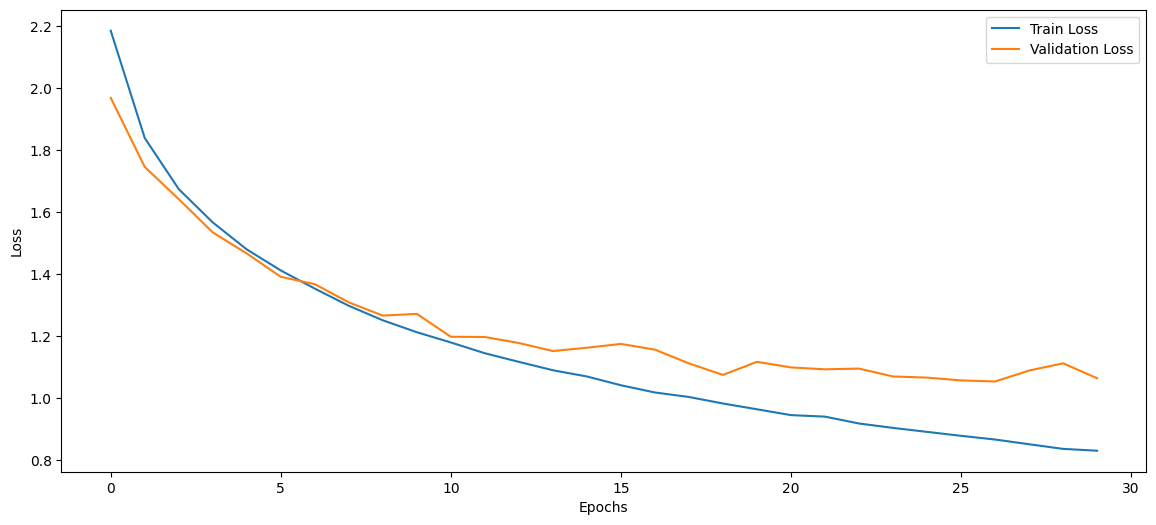

In [9]:
plt.plot(train_loss_history, label='Train Loss')
plt.plot(test_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Testing the network on the test data

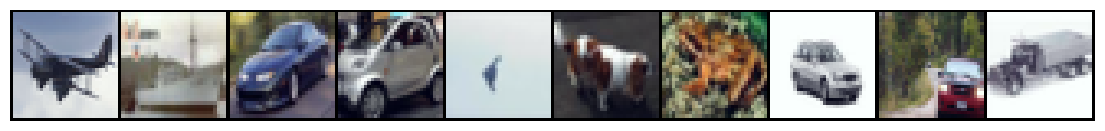

airplane ship automobile automobile airplane dog frog automobile automobile truck 

In [11]:
dataiter = iter(validation_loader)
images, labels = next(dataiter)
plt.imshow(np.transpose(torchvision.utils.make_grid(
images[:10], normalize=True, padding=1, nrow=10).numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()
labels_now = labels[:10]
for x in labels_now.tolist():
  print(label_names[x], end=" ")

In [12]:
net = Net().to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [13]:
outputs = net(images.to(device))

In [14]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{label_names[predicted[j]]:5s}'
                              for j in range(10)))

Predicted:  airplane ship  automobile automobile airplane horse frog  automobile deer  truck


Network performance on the whole dataset.

In [15]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = net(inputs)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 65 %


In [16]:

correct_pred = {classname: 0 for classname in label_names}
total_pred = {classname: 0 for classname in label_names}


with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)

        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[label_names[label]] += 1
            total_pred[label_names[label]] += 1



for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: airplane is 70.6 %
Accuracy for class: automobile is 75.9 %
Accuracy for class: bird  is 53.0 %
Accuracy for class: cat   is 42.4 %
Accuracy for class: deer  is 55.5 %
Accuracy for class: dog   is 52.5 %
Accuracy for class: frog  is 73.8 %
Accuracy for class: horse is 73.9 %
Accuracy for class: ship  is 79.1 %
Accuracy for class: truck is 76.9 %
